In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from datetime import datetime, timedelta
import orekit
import time
import pymsis
from pymsis import msis
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import hrd_20250608.utilities_ds as u
from orekit.pyhelpers import download_orekit_data_curdir, setup_orekit_curdir
from os import path
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.linalg import expm, logm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import hrd_20250608.rope_class_hrd as rope 

In [2]:
# download_orekit_data_curdir( 'hrd_20250608/orekit-data.zip' )  # Comment this out once this file has already been downloaded for repeated runs
vm = orekit.initVM()
setup_orekit_curdir( './hrd_20250608/' )

print ( 'Java version:', vm.java_version )
print ( 'Orekit version:', orekit.VERSION )

# User inputs
forward_propagation_mins = 1  # forward propagation time (mins)
init_date = pd.to_datetime('2003-05-10 00:00:00')

latitude_values = [89.]  # degrees
local_time_values = [8.]  # hours
altitude_values = [358.]  # km
lla_array = np.vstack((latitude_values, local_time_values, altitude_values)).T.reshape((-1, 3))

# Prepare to store results
all_dmd_outputs = []

# Loop over 1 day (1440 minutes), propagating 1 min at a time
current_date = init_date
minutes_in_day = 24 * 60
for i in range(minutes_in_day):
    sindy = rope.rope_propagator()
    sindy.propagate_models_mins(init_date=current_date, forward_propagation=forward_propagation_mins)
    all_dmd_outputs.append(sindy.z_dict['dmd'][:,-1][:, np.newaxis])
    current_date += pd.Timedelta(minutes=forward_propagation_mins)

# Concatenate all outputs along the time axis 
all_dmd_outputs = np.concatenate(all_dmd_outputs, axis=1)
print("Stepwise shape:", all_dmd_outputs.shape)
df_stepwise = pd.DataFrame(data=all_dmd_outputs)

Java version: 1.8.0_412
Orekit version: 13.0.1
Stepwise shape: (10, 1440)


In [22]:
# Now run the original implementation: propagate for one day in a single call
sindy_full = rope.rope_propagator()
sindy_full.propagate_models(init_date=init_date, forward_propagation=1)
dmd_full = sindy_full.z_dict['dmd']
print("Full shape:", dmd_full.shape)
df_full = pd.DataFrame(data=dmd_full)

# Align shapes for comparison (in case of off-by-one)
min_cols = min(df_stepwise.shape[1], df_full.shape[1])
df_stepwise = df_stepwise.iloc[:, :min_cols]
df_full = df_full.iloc[:, :min_cols]


Maximum available time T = 86340s
Full shape: (10, 1440)


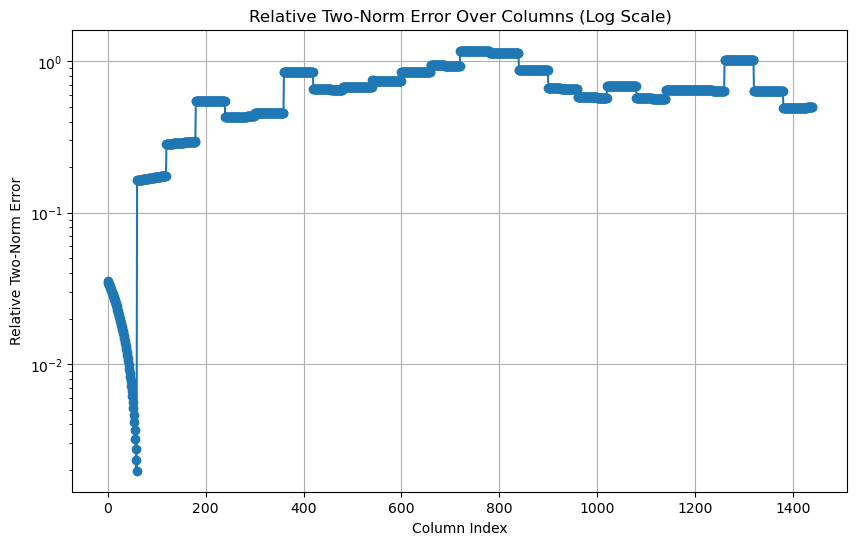

In [26]:
# Calculate the difference between full and stepwise dataframes
diff = df_full.values - df_stepwise.values

# Compute the relative two-norm error for each column
relative_two_norm_error = np.linalg.norm(diff, ord=2, axis=0) / np.linalg.norm(df_full.values, ord=2, axis=0)

# Plot the relative two-norm error in log scale over the columns using a semilogy plot
plt.figure(figsize=(10, 6))
plt.semilogy(relative_two_norm_error, marker='o')
plt.title('Relative Two-Norm Error Over Columns (Log Scale)')
plt.xlabel('Column Index')
plt.ylabel('Relative Two-Norm Error')
plt.grid(True)
plt.show()
